In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from scipy import asarray as ar,exp

In [2]:
hdu = fits.open('HE0232-0900.wo_absorption.fits')
#hdu.info()
qso_data = hdu[0].data
qso_error = hdu[1].data
qso_header = hdu[0].header
wavestart = qso_header['CRVAL3']
wavint = qso_header['CD3_3']
#wave = wavestart+np.arange(qso_data.shape[0])*wavint. This is the same as the one below. 
[central_x,central_y]= [67,51]#

In [3]:
z = 0.043143
k = 1+z

In [4]:
wave = np.arange(wavestart,(wavestart+(wavint*qso_data.shape[0])),wavint)#start,stop,step
select =(wave>6370*k)&(wave<6790*k)

In [5]:
y = qso_data[:,51,67][select]
x = wave[select]
y_err = qso_error[:,51,67][select]

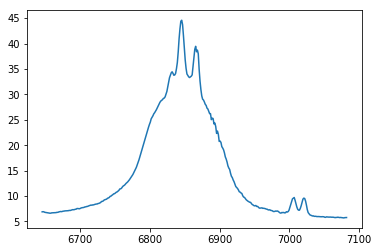

In [6]:
plt.plot(x,y)
plt.show()

In [7]:
#6529.03=NI
#6549.86=NII
#6564.61=Hα
#6585.27=NII
#6718.29=SII
#6732.67=SII#If we doublet, they're coupled(the velocity and velocity dispersion).
#[NII] and [SII] got blue wing

In [8]:
def redshift(vel):
    return vel/300000.0

def line_width(vel_sigma,rest_line,inst_res_fwhm=2.4):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

def gauss(wave,amplitude,vel,vel_sigma, rest_wave):
    line = (amplitude)*exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_wave))**2))
    return line 

def SII_doublet_gauss(wave,amp_SII6716,amp_SII6731,vel,vel_sigma):
    SII_6716 = gauss(wave,amp_SII6716,vel,vel_sigma,6716)
    SII_6731 = gauss(wave,amp_SII6731,vel,vel_sigma,6731)
    return SII_6716+SII_6731

def NII_doublet_gauss(wave,amp_NII6583,vel,vel_sigma):
    NII_6548 = 0.33*gauss(wave,amp_NII6583,vel,vel_sigma,6548)
    NII_6583 = gauss(wave,amp_NII6583,vel,vel_sigma,6583)
    return NII_6548+NII_6583

def NI_gauss(wave,amp_NI6529,vel,vel_sigma):
    NI_6529 = gauss(wave,amp_NI6529,vel,vel_sigma,6529)
    return NI_6529

def Ha_gauss(wave,amp_Ha,vel,vel_sigma):
    Ha = gauss(wave,amp_Ha,vel,vel_sigma,6562.8)
    return Ha

In [9]:
def full_gauss_complex(p,wave,data,error):
    (amp_NI6529,vel_NI6529,vel_sigma_NI6529,amp_Ha,vel_Ha,vel_sigma_Ha,amp_NII6583,vel_NII6583,vel_sigma_NII6583,amp_NII6583_br,vel_NII6583_br,vel_sigma_NII6583_br,amp_SII6716,amp_SII6731,vel_SII6731,vel_sigma_SII6731,amp_SII6716_br,amp_SII6731_br,vel_SII6731_br,vel_sigma_SII6731_br,m,c)=p
    NI = NI_gauss(wave,amp_NI6529,vel_NI6529,vel_sigma_NI6529)
    Ha = Ha_gauss(wave,amp_Ha,vel_Ha,vel_sigma_Ha)
    narrow_NII = NII_doublet_gauss(wave,amp_NII6583,vel_NII6583,vel_sigma_NII6583)
    broad_NII = NII_doublet_gauss(wave,amp_NII6583_br,vel_NII6583_br,vel_sigma_NII6583_br)
    broad_NII = 0
    narrow_SII = SII_doublet_gauss(wave,amp_SII6716,amp_SII6731,vel_SII6731,vel_sigma_SII6731)
    broad_SII = SII_doublet_gauss(wave,amp_SII6716_br,amp_SII6731_br,vel_SII6731_br,vel_sigma_SII6731_br) 
    broad_SII = 0
    cont = (wave/1000.0)*m+c
    return (NI+Ha+narrow_NII+broad_NII+narrow_SII+broad_SII+cont-data)/error


In [10]:
p_init=(0.1,12942,10,23,12942,2000,12,12942,40,0.2,12742,40,1,1,12942,20,0.5,0.5,12742,20,-0.1,0.7)


In [11]:
popt,pcov = leastsq(full_gauss_complex,x0=p_init,args=(x,y,y_err))
print(popt)
[amp_NI6529,vel_NI6529,vel_sigma_NI6529,amp_Ha,vel_Ha,vel_sigma_Ha,amp_NII6583,vel_NII6583,vel_sigma_NII6583,amp_NII6583_br,vel_NII6583_br,vel_sigma_NII6583_br,amp_SII6716,amp_SII6731,vel_SII6731,vel_sigma_SII6731,amp_SII6716_br,amp_SII6731_br,vel_SII6731_br,vel_sigma_SII6731_br,m,c] = popt
fit = full_gauss_complex(popt,x,y,y_err)*y_err+y
residual = y - fit

[  1.45249645e+00   9.44309475e+03   1.23976187e+03   2.97052252e+01
   1.29968022e+04   1.96777825e+03   4.42397019e+00   1.28846374e+04
   7.16014160e+01   2.00000000e-01   1.27420000e+04   4.00000000e+01
   3.52477790e+00   3.31475777e+00   1.29311834e+04   1.68645121e+02
   5.00000000e-01   5.00000000e-01   1.27420000e+04   2.00000000e+01
  -2.09051616e+00   2.07831832e+01]


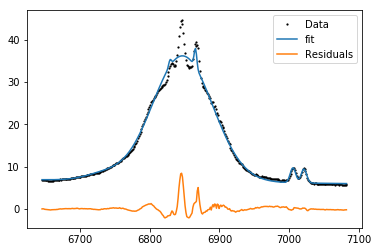

In [12]:
plt.plot(x,y,'ko',markersize=1.2,label='Data')
plt.plot(x,fit,label='fit')
plt.plot(x,residual,label='Residuals')
#plt.plot(x,NI_gauss(x,amp_NI6529,vel_NI6529,vel_sigma_NI6529),'-g')
#plt.plot(x,Ha_gauss(x,amp_Ha,vel_Ha,vel_sigma_Ha),'-m')
#plt.plot(x,NII_doublet_gauss(x,amp_NII6583,vel_NII6583,vel_sigma_NII6583),'-b')
#plt.plot(x,NII_doublet_gauss(x,amp_NII6583_br,vel_NII6583_br,vel_sigma_NII6583_br),'-k')
#plt.plot(x,SII_doublet_gauss(x,amp_SII6716,amp_SII6731,vel_SII6731,vel_sigma_SII6731),'-c')
#plt.plot(x,SII_doublet_gauss(x,amp_SII6716_br,amp_SII6731_br,vel_SII6731_br,vel_sigma_SII6731_br) ,'-r')
plt.legend()
plt.show()